<center> <h1>Fatalities in car accidents by miles driven</h1></center>

The problem we are going to take into consideration is fatalities in car accidents correspoding to miles driven each year. We have chosen data from 1930-1960 since it would be more accurate and also covers the time of WWII which will occure as significant drops in miles driven and will provide a variety of data used.

The real reason to creat such a model is to analyze and predict future years and possibly com out with some solutions that could guarantee us better safety and less fatal accidents in the future.

In [2]:
from cmdstanpy import CmdStanModel
import pandas as pd
import arviz as az 
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats

Below you can see a sample of the data we had downloaded.

In [3]:
df = pd.read_csv("cars_fatalities.csv", index_col=0)
df.head()

,Fatalities,Vehicles,Miles
Year,,,
1930,32900,26.7,206
1931,33700,26.1,216
1932,29500,24.4,200
1933,31363,24.2,201
1934,36101,25.3,216


We have chosen data from NSC injury facts since they provide reliable data. Also, we have decided to focus on a country of USA and as we mentioned before years 1930-1960.

https://injuryfacts.nsc.org/motor-vehicle/historical-fatality-trends/deaths-and-rates/
 

The data we had downloaded contains Fatalities, Miles driven and number of vehicle for each year in the USA. This set of data will allow us to creat such a model.

The chart before presents the data over the years. You can see the drop during WWII in fatalities.

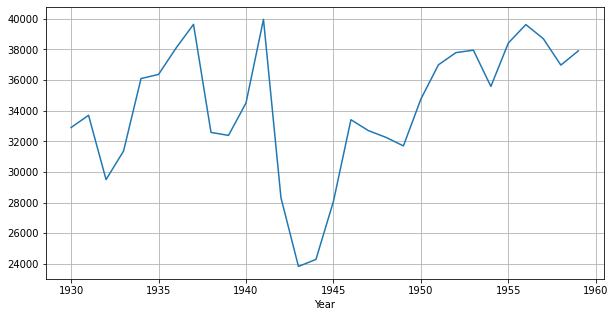

In [5]:
df['Fatalities'].plot(figsize=(10,5), grid=True)
plt.show()


Below you can see a histogram of fatalities in the years of 1930-1960

<AxesSubplot:>

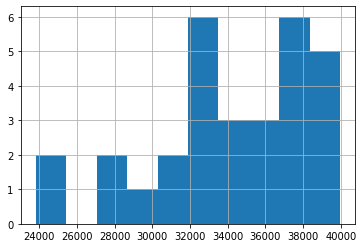

In [7]:
df["Fatalities"].hist(bins =10)

<h1>FIRST MODEL</h1>

For the first model, we have chosen linear regression. Firstly in our project, we tried to observe the data and come out wth some solutions. Therefore, we have seen a linear dependence between the two factor which are fatalities and miles driven. As for that we will proceed with the linear regression model.

Since the data for USA may have a little correlation with data in Poland, after a bit of consideration let's look at the priors this way. Around 10 people die a day in Poland in a car accident, that makes 3650 people a year in, a 38mln of a population, country. In USA lives around 9 times more people. Having all of that we come out with around 33000 people dying each year in car accidents in USA. And we will proceed with this prior.

First of all, we are creating prior check. Our simple model will generate the data based on our priors. After that we will try to figure out if that is the right choice.

In [9]:
model1_ppc=CmdStanModel(stan_file='first_ppc.stan')

INFO:cmdstanpy:found newer exe file, not recompiling


In [18]:
R = 1000
sim=model1_ppc.sample(iter_sampling=R,
                     iter_warmup=0,
                     chains=1,
                     fixed_param=True,
                     seed=29042020,refresh=R)

INFO:cmdstanpy:CmdStan start processing
chain 1 |██████████| 00:00 Sampling completed


INFO:cmdstanpy:CmdStan done processing.


In [25]:
sim = sim.draws_pd()

AttributeError: 'DataFrame' object has no attribute 'draws_pd'

We can observe on the two histograms that the data is similar and we had reached a satisfying level.

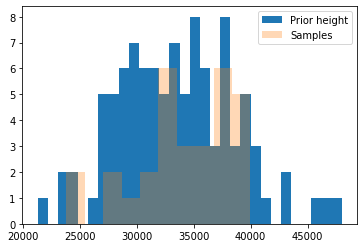

In [24]:
sim['deaths'][0:100].hist(bins=30)
df['Fatalities'].hist(alpha=0.3)
plt.legend(['Prior height', 'Samples'])
plt.grid()
plt.show()

After this we will proceed to  posterior analysis. In the next few steps we will compile the model, sample it and try to show some data.

In [26]:
model_1_fit=CmdStanModel(stan_file='first_fit.stan')

INFO:cmdstanpy:found newer exe file, not recompiling


In [27]:
data_fit={'N':len(df), 'Miles':df['Miles'], 'deaths':df['Fatalities']}
fit=model_1_fit.sample(data=data_fit,seed=29042020)
fit_car_lin = fit

INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status





chain 1 |▉         | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


INFO:cmdstanpy:CmdStan done processing.


No issues with the sampling had occured. We had recived a data that will be presented below.

   alpha ~ normal(33000,6000)

   beta ~ lognormal(0,1)

   sigma ~ exponential(0.08)

The alpha, beta, sigma parameters were chosen as above. We had previously explained the choice of alpha. For beta it was a trial and error method, lognormal(0,1) turned our slightly better than normal(0,1). Since the data we had chosen can be quite vary we decided to choose exp(0.08) to have it vary a lot.

We can observe the values generated by the model.

In [17]:
beta = fit.stan_variable('beta')
alpha = fit.stan_variable('alpha')
az.summary(fit, var_names=['beta','sigma','alpha'],round_to=2, kind='stats')

,mean,sd,hdi_3%,hdi_97%
beta,14.35,1.75,11.29,17.74
sigma,1546.45,77.11,1407.75,1695.72
alpha,28829.96,714.07,27420.00,30098.30


Trzeba opisać co to jest z wykładu na YT

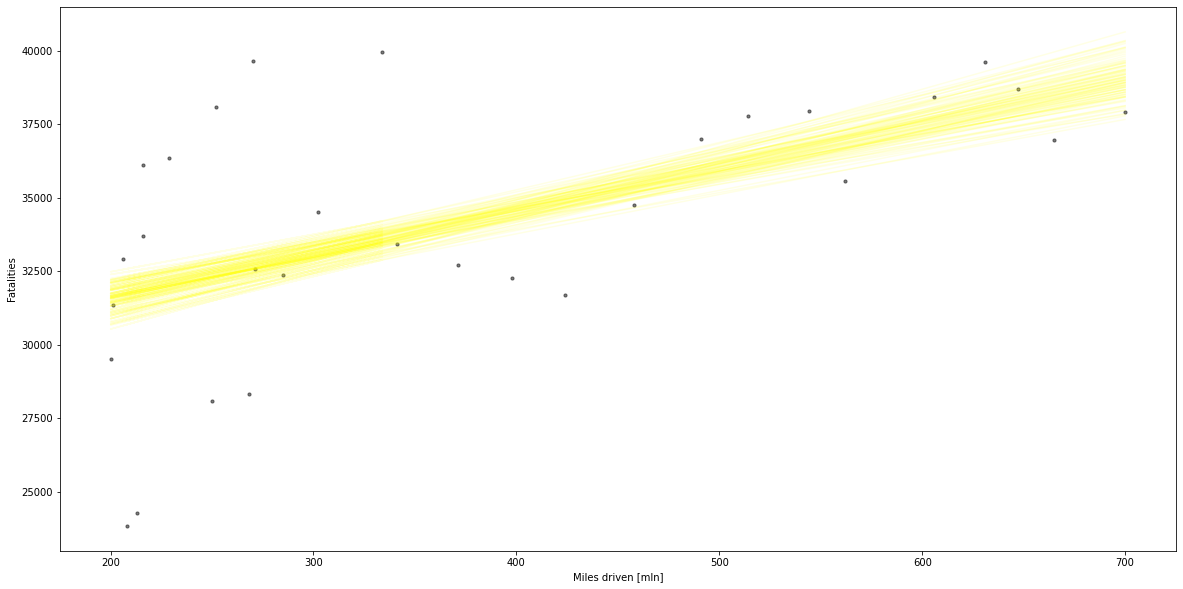

In [18]:
fig, axes = plt.subplots(1,1,figsize=(20,10))
for i in range(100):
    axes.plot(df.Miles,
    alpha[i]+beta[i]*df.Miles, alpha=0.1, color='yellow')
plt.xlabel("Miles driven [mln]")
plt.ylabel("Fatalities")
axes.scatter(df.Miles, df.Fatalities, color='black',alpha=0.5,s=10)

    

Below we can see how to model reacts for the miles  and what values are returned. We can see that the chart is similar to the actual data throughout the years.

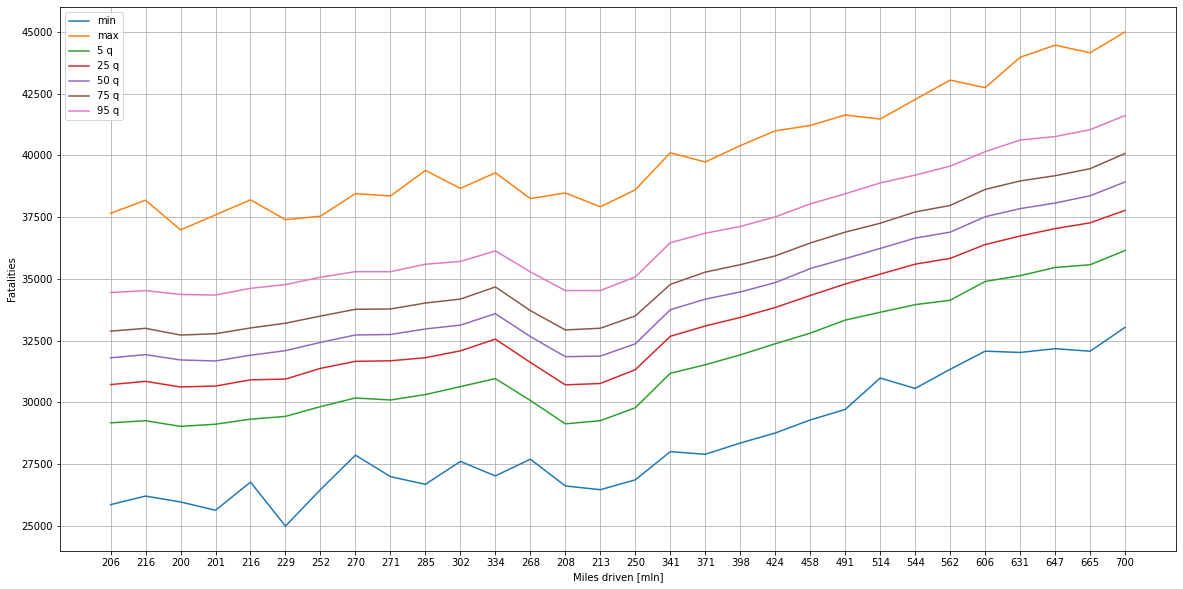

In [29]:
fit_height = fit.draws_pd()
fit_height = fit_height.loc[:,'death[1]':'death[30]']
data2 = {'min' : fit_height.min(),
        'max' : fit_height.max(),
        '5 q' : fit_height.quantile(0.05),
        '25 q' : fit_height.quantile(0.25),
        '50 q' : fit_height.quantile(0.5),
        '75 q' : fit_height.quantile(0.75),
        '95 q' : fit_height.quantile(0.95)}

fit_data = pd.DataFrame(data2)
fit_data.plot(figsize=(20,10))
plt.xlabel("Miles driven [mln]")
plt.ylabel("Fatalities")
default_x_ticks = range(len(df.Miles))
plt.xticks(default_x_ticks, df.Miles)
plt.grid()


Since the results of the model look promising, lets try to predict the future years. for the year 1961 the numer of miles driven is 719. Let's combine that with the alpha and beta recived from the model.

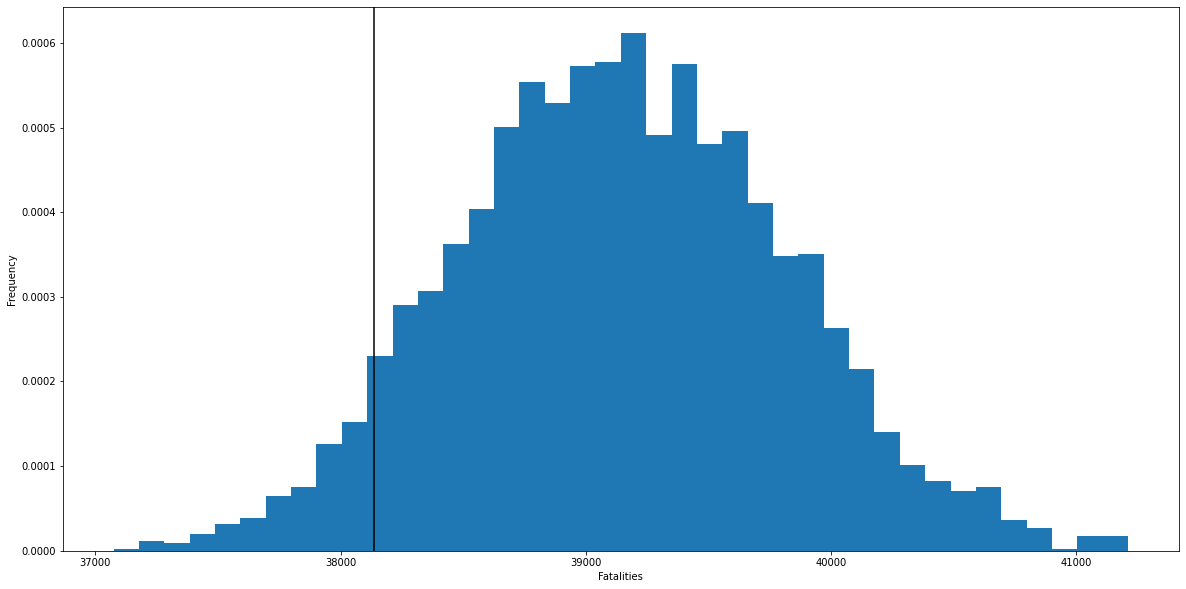

In [21]:
mu3500 = alpha+beta*(719)
fig, ax = plt.subplots(1,1,figsize=(20,10))
ax.hist(mu3500,bins=40,density=True)
plt.axvline(x = 38137, color = 'black', label = 'Actual data for 201mln miles')
plt.xlabel("Fatalities")
plt.ylabel("Frequency")
plt.show()

Let's take a closer look. Histogram presented above shows us generated by the model data of prdeicted deaths for year 1961. Black line is the actual value. We can see that the results recived are quite satisfying.

LINEAR MODEL HISTOGRAMS WITH ACTUAL VALUE

To have the closest look to what w had recived we will plot histograms for each year of 1930-1960 and mark the actual value with a black line just as we did above. 

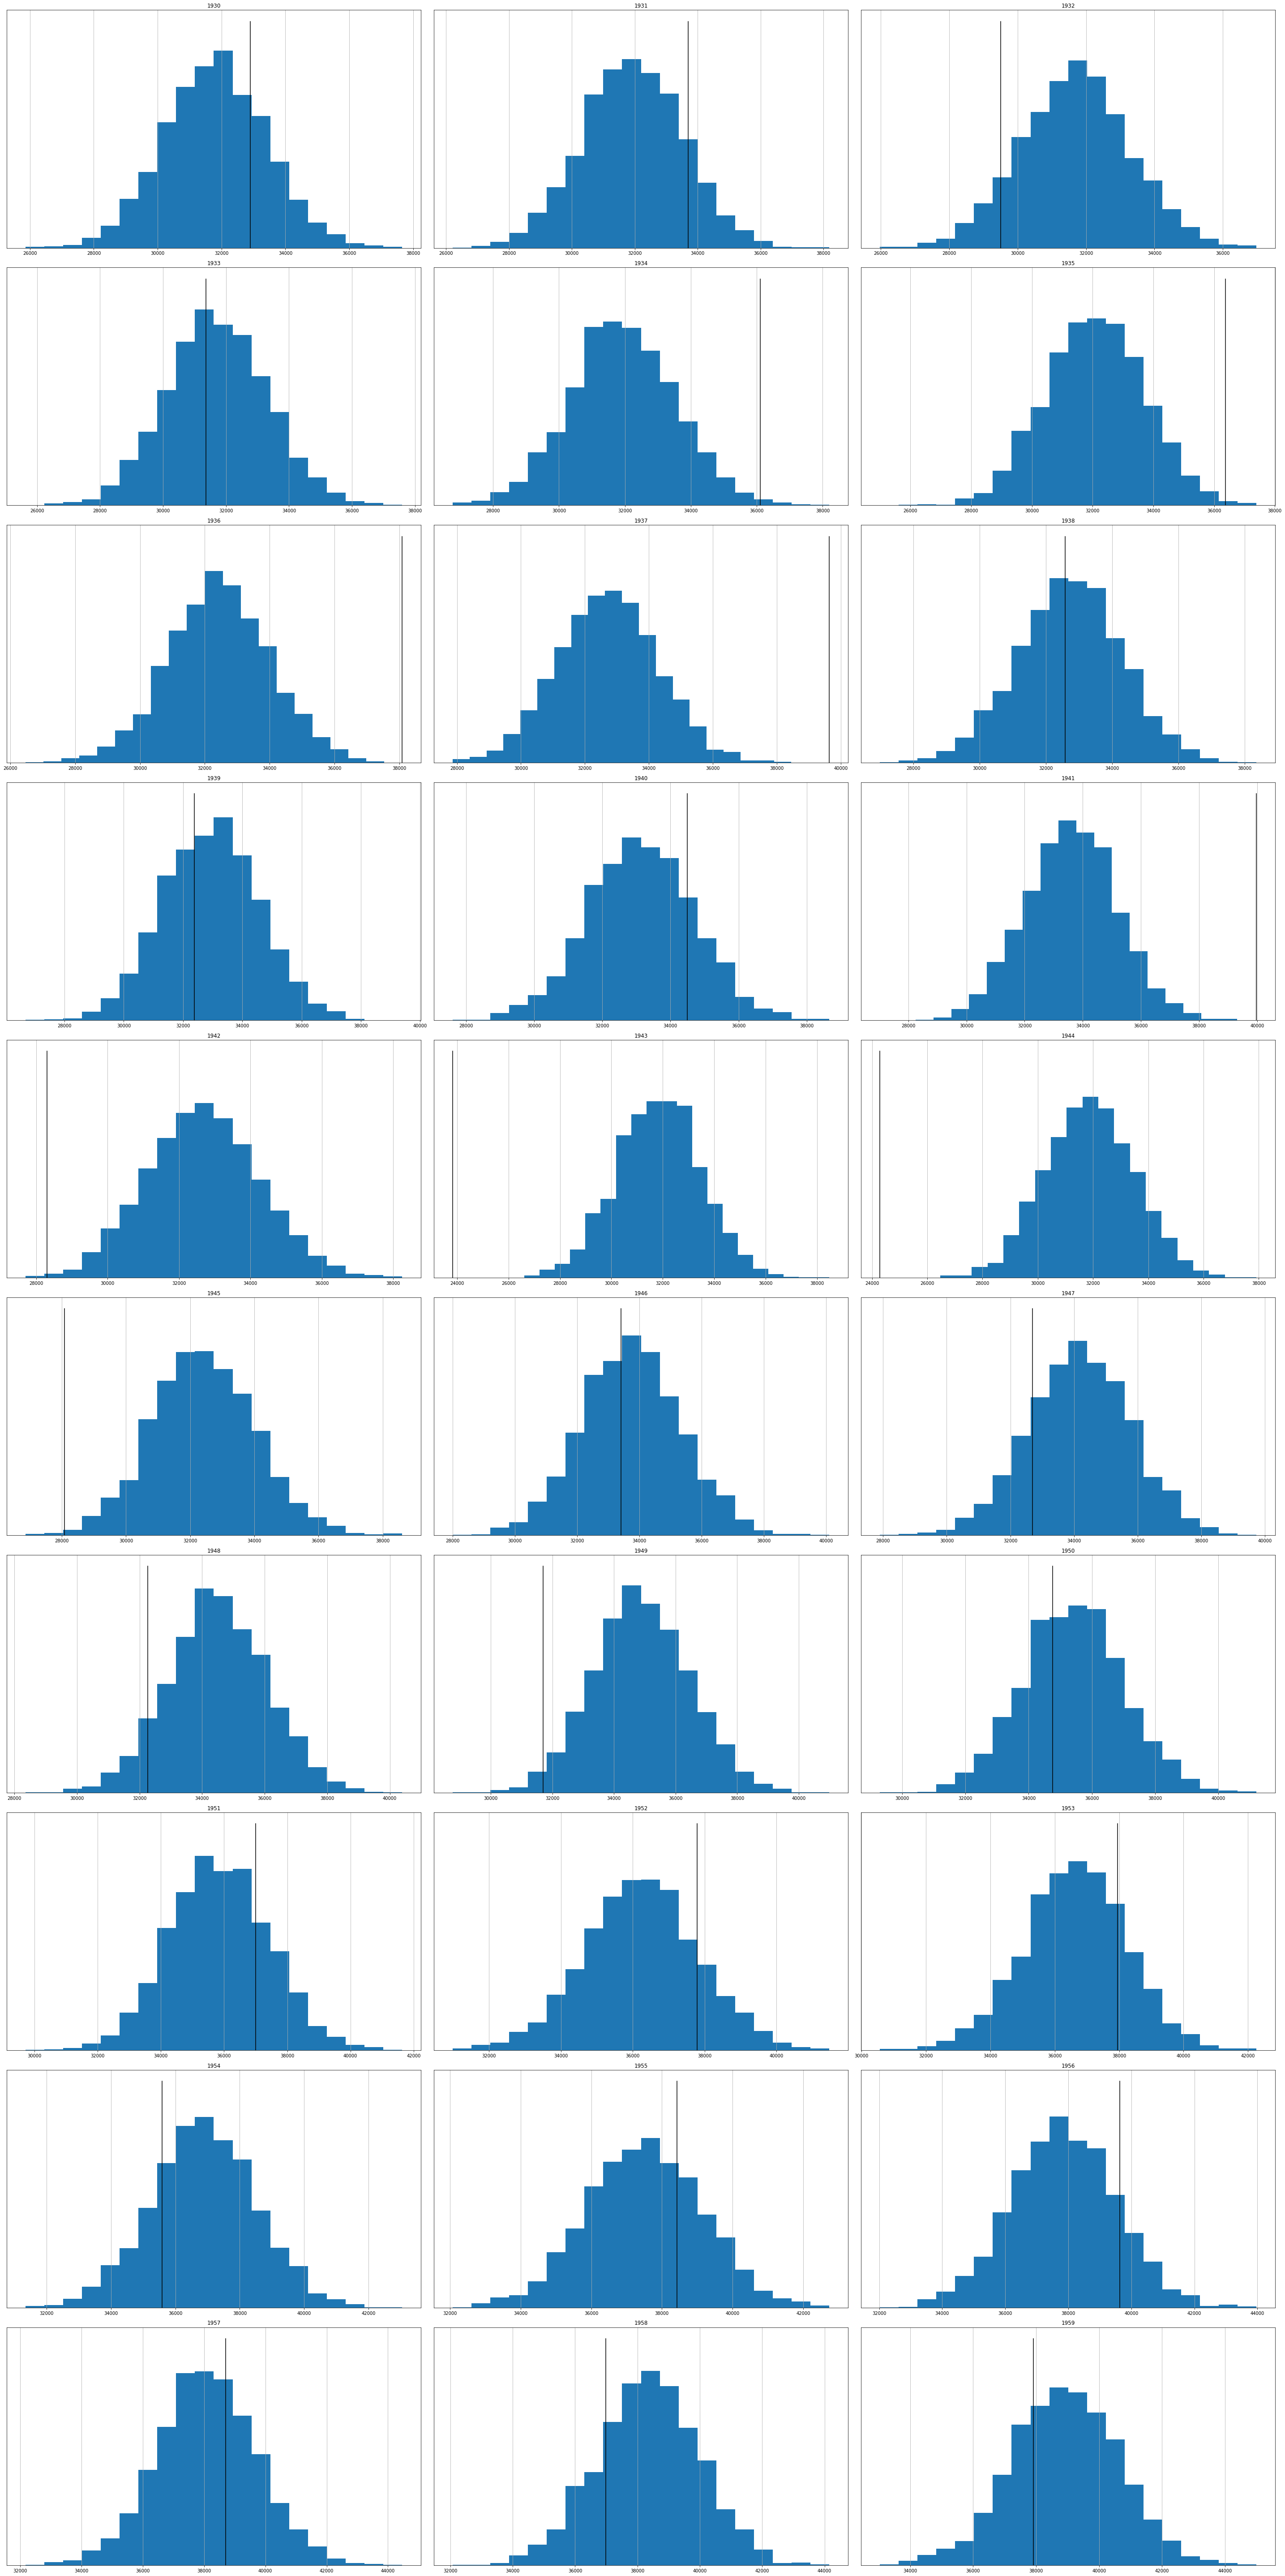

In [22]:
aaa = fit_height
fig, axes = plt.subplots(10, 3, figsize=(40, 80), sharey=True, squeeze=False)
axes_flat = axes.flatten()
tvn = df["Fatalities"].tolist()
for k, ax in enumerate(axes_flat):
    string = "death["+ str(k+1) + "]"
    ax.hist(fit_height[string], bins=20)
    ax.set_title(df['Year'][k])
    tv=tvn[k]
    ax.plot([tv, tv], [0, 700], color='black')
    ax.set_yticks([])
    ax.grid()
fig.tight_layout()
plt.show()

We can see that the model had come out with rather satisfying results. There are some major differances in years of WWII which obviously makes sense. This can be for some reasons. First of all, actual data, gathered during the war, is probably not what it really was. And also, war has a huge influence on the data as well, even though it is data for USA.

<center><h1>SECOND MODEL</h1></center>

## Poisson distribution
Poisson distribution was chosen as a second model. It’s discrete probability distribution that expresses the probability of a given number of events (number of fatalities) occurring in a fixed interval of time or space (yearly) with a known constant mean rate and independently of the time since the last event.

Modelling was started by proposing very simple model, with an assumption, that People deaths number $y_i$ has a Poisson distribution$$y_i\sim\mathrm{Poisson}(\lambda)$$with a rate $\lambda$ independent on year or miles flown.

Lets assume that 1500 people dying every day has very low probability (1500*365=547500). Following equation should be fullfilled: $$\lambda + 3\sqrt{\lambda} \approx 547500$$ which means that probability is less than 1%.

In [23]:
prob = 365*1500.
root_of_lam = np.polynomial.polynomial.polyroots([-1*prob,3.,1.])
lam_ub = np.round(root_of_lam[root_of_lam > 0]**2)

In [24]:
deaths = []
dta_cnt = []
for k in df['Fatalities']:  
    dta_cnt.append(-(1. + deaths.count(k)))
    deaths.append(k)
dta_cnt = np.array(dta_cnt)

Stan code printed below is used to find parameter $\sigma$ of half normal distribution that cause most values to be spread between 0 and $\lambda$.

In [25]:
model = CmdStanModel(stan_file='prior_tune.stan')

INFO:cmdstanpy:found newer exe file, not recompiling


In [26]:
data = dict(y_guess=np.array([np.log(100000)]), theta=np.array(lam_ub))
sim = model.sample(data=data,
                     iter_sampling=1, 
                     iter_warmup=0,
                     chains=1,
                     fixed_param=True,
                     seed=1052020)
sigma = np.round(sim.stan_variable('sigma')[0])
print(sigma)

INFO:cmdstanpy:CmdStan start processing
chain 1 |██████████| 00:00 Sampling completed


INFO:cmdstanpy:CmdStan done processing.



211693.0


In [27]:
import math
def rounds(x):
    n = -1
    t = x
    while t>1:
        n += 1
        t = t/10
    dif = 10**n
    rou = int(math.ceil(x / dif)) * dif
    if rou-x>dif/2:
        rou = rou - dif/2
    return int(rou)

FIGURE OF POISSON DISTRIBUTION

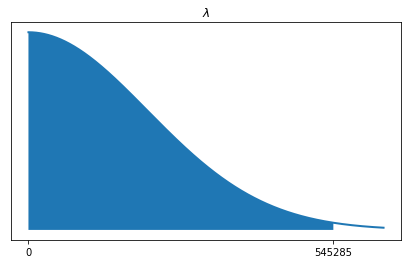

In [28]:
fig, ax2 = plt.subplots(1, 1,figsize=(7, 4))
x2 = np.linspace(0, 3*sigma, 1000)
x4 = np.linspace(0, lam_ub[0], 1000)
ax2.plot(x2, 2*stats.norm.pdf(x2,scale=sigma), linewidth=2)
ax2.fill_between(x4, 2*stats.norm.pdf(x4, scale=sigma), 0)
ax2.set_yticks([])
ax2.set_xticks([0, lam_ub[0]])
ax2.set_title(r'$\lambda$')
plt.show()

## Posterior inference and posterior predictive checks for second model

In [29]:
model_2 = CmdStanModel(stan_file='prior_pred.stan')

INFO:cmdstanpy:found newer exe file, not recompiling


In [30]:
R = 1000
sim_2 = model_2.sample(data=dict(M = 1, sigma=int(sigma)),
                     iter_sampling=R, 
                     iter_warmup=0,
                     chains=1,
                     fixed_param=True,
                     seed=2902020)

INFO:cmdstanpy:CmdStan start processing
chain 1 |██████████| 00:00 Sampling completed


INFO:cmdstanpy:CmdStan done processing.


There were no issues with sampling.

C:\Users\Filip\AppData\Local\Temp\ipykernel_24424\1122288886.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  ax1.annotate('HalfNormal(0,' + str(np.int(sigma)) + ')', xy=(150,arr_y_loc), xytext=(200,1.5*arr_y_loc), arrowprops={'arrowstyle':'->'})


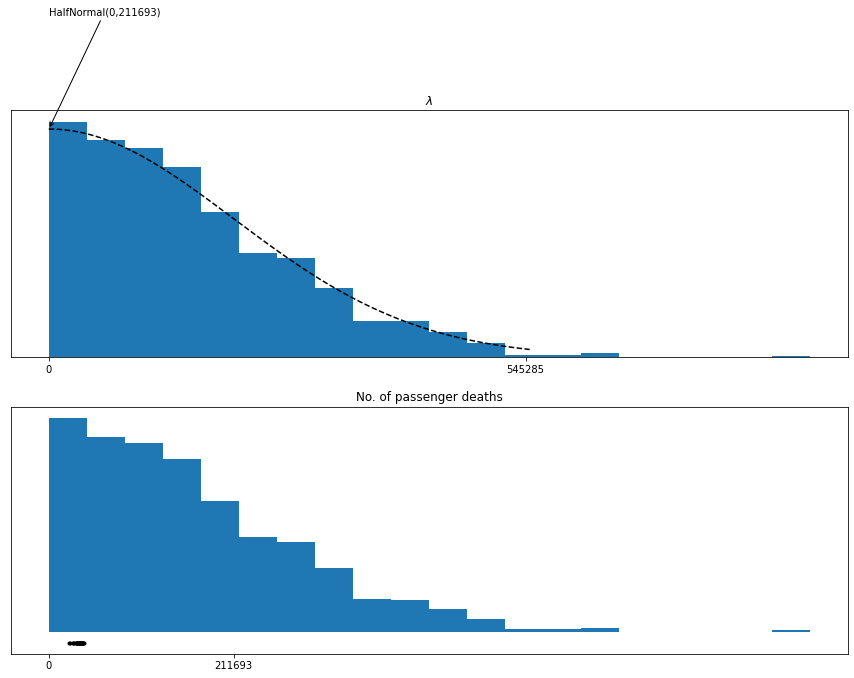

In [31]:
theta = sim_2.stan_variable('lambda')
y_sim = sim_2.stan_variable('y_sim')
fig, axes = plt.subplots(2, 1,figsize=(15, 10))
ax1 = axes[0]
ax1.hist(theta, bins=20, density=True)
x = np.linspace(0, rounds(lam_ub), 1000)
ax1.set_xticks([0, lam_ub[0]])
ax1.set_yticks([])
ax1.set_title(r'$\lambda$')
ax1.plot(x, 2 * stats.norm.pdf(x, 0, sigma), color='black', linestyle='--')
arr_y_loc = 2 * stats.norm.pdf(150,0,sigma)
ax1.annotate('HalfNormal(0,' + str(np.int(sigma)) + ')', xy=(150,arr_y_loc), xytext=(200,1.5*arr_y_loc), arrowprops={'arrowstyle':'->'})
ax2 = axes[1]
ax2.hist(y_sim.flatten(), density=True, bins=20, zorder=1)
ax2.scatter(deaths, 0.0000002 * dta_cnt, color='black', marker='.', zorder=2)
ax2.set_xticks([0,sigma])
ax2.set_yticks([])

ax2.set_title('No. of passenger deaths')
plt.show()

In [32]:
model_car = CmdStanModel(stan_file='car_posterior.stan')

INFO:cmdstanpy:found newer exe file, not recompiling


In [33]:
data_car = dict(M = len(df),
                y = np.round(df['Fatalities'].values),
                sigma=int(sigma))
fit_car = model_car.sample(data=data_car, seed=2902020)
lam = fit_car.stan_variable('lambda')
y_sim_c = fit_car.stan_variable('y_sim')

INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |██████▊   | 00:00 Iteration: 1200 / 2000 [ 60%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


INFO:cmdstanpy:CmdStan done processing.


In [34]:
mean_lam = np.mean(lam)
cinf_lam = az.hdi(lam, 0.89)
hdi_width = cinf_lam[1] - cinf_lam[0]

print('Mean lambda : {:4.2f}'.format(mean_lam))
print('89% confidence interval: [',*['{:4.2f}'.format(k) for k in cinf_lam],']')

Mean lambda : 34214.16
89% confidence interval: [ 34159.20 34267.20 ]


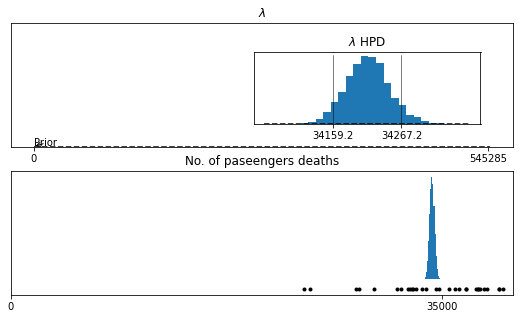

In [35]:
fig, axes = plt.subplots(2, 1,figsize=(9, 5))
ax1 = axes[0]
ax1.hist(lam, bins=20, density=True)
x = np.linspace(0, int(prob), 1000)

ax1.plot(x, 2 * stats.norm.pdf(x, 0, sigma), color='black', linestyle='--')
arr_y_loc = 2 * stats.norm.pdf(50, 0, sigma)
ax1.annotate(text='Prior', xy=(50, arr_y_loc), xytext=(100, 10 * arr_y_loc), arrowprops={'arrowstyle':'->'})
ax1.set_xticks([0, lam_ub[0]])
ax1.set_yticks([])
ax1.set_title(r'$\lambda$')

ax_sm = plt.axes([0.5,0.6,0.35,0.2])
x_sm = np.linspace(cinf_lam[0]-hdi_width,cinf_lam[1]+hdi_width,200)
ax_sm.hist(lam, bins=20, density=True)
ax_sm.plot(x_sm, 2 * stats.norm.pdf(x_sm, 0, sigma), color='black', linestyle='--')
ax_sm.annotate(text='', xy=(cinf_lam[0] - .2, 0.2), xytext=(cinf_lam[1] + .2, 0.2), arrowprops=dict(arrowstyle='<->'))
ax_sm.plot([cinf_lam[0], cinf_lam[0]], [0, 0.012], color='black', linestyle='-', linewidth=0.5)
ax_sm.plot([cinf_lam[1], cinf_lam[1]], [0, 0.012], color='black', linestyle='-', linewidth=0.5)

ax_sm.set_xticks(np.round([cinf_lam[0], cinf_lam[1]],2))
ax_sm.set_yticks([])
ax_sm.set_title(r'$\lambda$ HPD')


ax2 = axes[1]
ax2.hist(y_sim_c.flatten(), density=True, bins=20, zorder=1)
ax2.scatter(deaths, 0.0002 * dta_cnt, color='black', marker='.', zorder=2)
ax2.set_xticks([0, np.max(y_sim_c)])

ax2.set_yticks([])

ax2.set_title('No. of paseengers deaths')
plt.show()

Model has predicted relatively close value if a little lower than expected. Real value of vatalities in 1961 was 38091. 

Received value (34214) was about 10% lower than real value, so it's a quite good result. 

MODEL COMPARISION

c:\Users\Filip\anaconda3\envs\Modelowanie\lib\site-packages\arviz\stats\stats.py:694: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
c:\Users\Filip\anaconda3\envs\Modelowanie\lib\site-packages\arviz\stats\stats.py:248: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ics = ics.append([ic_func(dataset, pointwise=True, scale=scale, var_name=var_name)])
c:\Users\Filip\anaconda3\envs\Modelowanie\lib\site-packages\arviz\stats\stats.py:694: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using

         rank           loo        p_loo        d_loo   weight           se  \
fit_poi     0 -10816.896043  3729.536171     0.000000  0.80002  2815.221172   
fit_lin     1 -13856.756309  3319.608086  3039.860266  0.19998   377.861618   

                 dse  warning loo_scale  
fit_poi     0.000000     True       log  
fit_lin  2819.062646     True       log  
         rank          waic        p_waic       d_waic  weight           se  \
fit_lin     0 -22846.421061  12309.272838     0.000000     0.5  2486.848021   
fit_poi     1 -25835.241866  18747.881994  2988.820804     0.5  8106.917190   

                 dse  warning waic_scale  
fit_lin     0.000000     True        log  
fit_poi  8495.258694     True        log  


<AxesSubplot:xlabel='Log'>

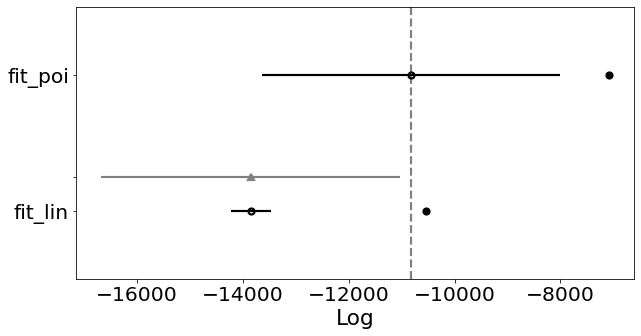

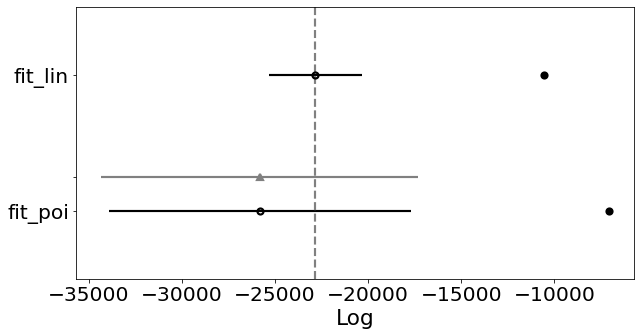

In [37]:
compare_dict = {'fit_lin': fit, 'fit_poi': fit_car}
loo_compare = az.compare(compare_dict, ic="loo")
waic_compare = az.compare(compare_dict, ic="waic")
print(loo_compare)
print(waic_compare)
az.plot_compare(loo_compare, figsize=(10,5))
az.plot_compare(waic_compare, figsize=(10,5))

OPISAĆ RÓŻNICE MIĘDZY MODELAMI